In [1]:
#!/usr/bin/env python3
"""
Neven Caplar 
Last updated: 2023-11-30

Goals: 
Fit the Tape Single data

TODO:
Check the results; they seems to be unreasonable for some lightcurves

Each Section can/should run independently,
only these initial imports should be shared among all sections

Open questions:
None at the moment
"""

import os

import numpy as np
import pandas as pd
import pyarrow as pa

# from scipy.spatial import KDTree
import matplotlib.pyplot as plt

import JaxPeriodDrwFit


from tape.ensemble import Ensemble
from tape.utils import ColumnMapper

from tqdm import tqdm

from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

In [2]:
import dask
# many workers
# dask.config.set(scheduler='threads') 

# dask.config.set({"temporary-directory" :'/epyc/ssd/users/ncaplar/tmp'})

# does not work
# from multiprocessing.pool import ThreadPool
# dask.config.set(pool=ThreadPool(20))

# one worker
# dask.config.set(scheduler='processes')  
from dask.distributed import Client, LocalCluster
cluster = LocalCluster(n_workers=12, threads_per_worker=1)
client = Client(cluster)
# cluster.adapt(minimum=10, maximum=40) 

/astro/users/ncaplar/.conda/envs/tape_static/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 45586 instead
  warnings.warn(


In [3]:
dask.config.get("temporary-directory")

In [4]:
ens = Ensemble(client = client)  # initialize an ensemble object
ens.client_info()

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:45586/status,
Dashboard: http://127.0.0.1:45586/status,Workers: 12
Total threads: 12,Total memory: 251.68 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:45524,Workers: 12
Dashboard: http://127.0.0.1:45586/status,Total threads: 12
Started: Just now,Total memory: 251.68 GiB
Comm: tcp://127.0.0.1:45558,Total threads: 1
Dashboard: http://127.0.0.1:46831/status,Memory: 20.97 GiB
Nanny: tcp://127.0.0.1:35633,


In [5]:
dask.config.get("temporary-directory")

In [6]:
# Setup base directory for saving output files
username= "ncaplar"
basedir = f"/astro/users/{username}/data/"

# Tape Single Pixel

In [15]:
# if running on baldur or epyc
data_path = "/astro/store/epyc/data3/hipscat/catalogs/tape_test/"

col_map = ColumnMapper(id_col="SDSS_NAME_dr16q_constant", 
                       time_col="mjd_ztf_source",
                       flux_col="mag_ztf_source", 
                       err_col="magerr_ztf_source",
                       band_col="band_ztf_source")

ens.from_hipscat(data_path,
                 source_subdir="tape_test_sources",
                 object_subdir="tape_test_obj",
                 column_mapper=col_map,
                 additional_cols=True,
                 sync_tables=False,
                 sort=False,
                 )

/astro/users/ncaplar/.conda/envs/tape_static/lib/python3.10/site-packages/tape/ensemble.py:1286: UserWarning: Divisions for object are not set, certain downstream dask operations may fail as a result. We recommend setting the `sort` or `sorted` flags when loading data to establish division information.
  warnings.warn(
/astro/users/ncaplar/.conda/envs/tape_static/lib/python3.10/site-packages/tape/ensemble.py:1286: UserWarning: Divisions for source are not set, certain downstream dask operations may fail as a result. We recommend setting the `sort` or `sorted` flags when loading data to establish division information.
  warnings.warn(


In [17]:
ens.query("band_ztf_source == 'g'", table = 'source')
ens.prune(10)
ens.query("rMeanPSFMag_ps1_otmo < 20", table = 'object')

/astro/users/ncaplar/.conda/envs/tape_static/lib/python3.10/site-packages/tape/ensemble.py:1758: UserWarning: Divisions are not known, syncing using a non-lazy method.
  warnings.warn("Divisions are not known, syncing using a non-lazy method.")


ValueError: Metadata inference failed in `drop_by_shallow_copy`.

You have supplied a custom function and Dask is unable to 
determine the type of output that that function returns. 

To resolve this please provide a meta= keyword.
The docstring of the Dask function you ran should have more information.

Original error is below:
------------------------
KeyError("['nobs_total'] not found in axis")

Traceback:
---------
  File "/astro/users/ncaplar/.conda/envs/tape_static/lib/python3.10/site-packages/dask/dataframe/utils.py", line 194, in raise_on_meta_error
    yield
  File "/astro/users/ncaplar/.conda/envs/tape_static/lib/python3.10/site-packages/dask/dataframe/core.py", line 7043, in _emulate
    return func(*_extract_meta(args, True), **_extract_meta(kwargs, True))
  File "/astro/users/ncaplar/.conda/envs/tape_static/lib/python3.10/site-packages/dask/dataframe/utils.py", line 773, in drop_by_shallow_copy
    df2.drop(columns=columns, inplace=True, errors=errors)
  File "/astro/users/ncaplar/.conda/envs/tape_static/lib/python3.10/site-packages/pandas/core/frame.py", line 5258, in drop
    return super().drop(
  File "/astro/users/ncaplar/.conda/envs/tape_static/lib/python3.10/site-packages/pandas/core/generic.py", line 4549, in drop
    obj = obj._drop_axis(labels, axis, level=level, errors=errors)
  File "/astro/users/ncaplar/.conda/envs/tape_static/lib/python3.10/site-packages/pandas/core/generic.py", line 4591, in _drop_axis
    new_axis = axis.drop(labels, errors=errors)
  File "/astro/users/ncaplar/.conda/envs/tape_static/lib/python3.10/site-packages/pandas/core/indexes/base.py", line 6699, in drop
    raise KeyError(f"{list(labels[mask])} not found in axis")


In [ ]:
ens.source.divisions

(None, None, None, None, None)

(17.0, 21.0)

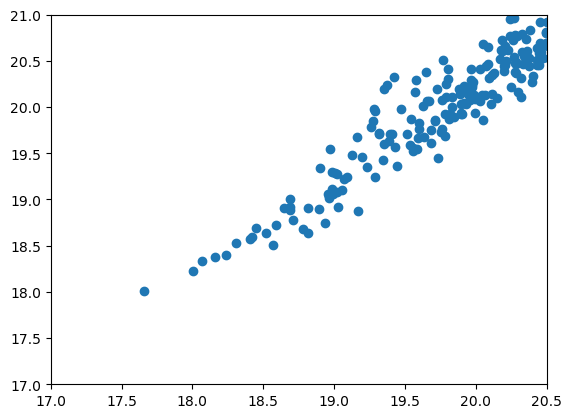

In [14]:
plt.scatter(ens.object['rMeanPSFMag_ps1_otmo'].compute().values, ens.object['gMeanPSFMag_ps1_otmo'].compute().values)
plt.xlim(17,20.5)
plt.ylim(17,21)

(17.0, 23.0)

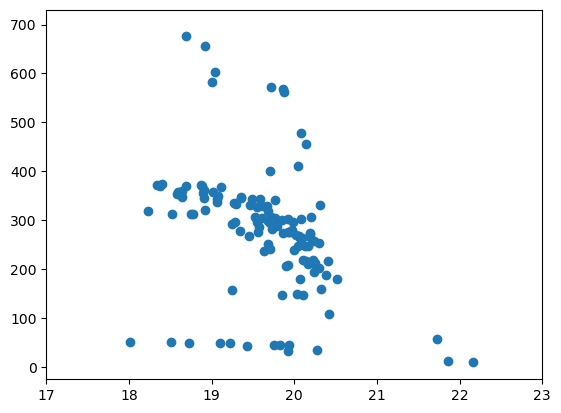

In [12]:
ens_nobs = ens.calc_nobs(temporary=False)

plt.scatter( ens._object['gMeanPSFMag_ps1_otmo'].compute().values,ens_nobs._object['nobs_total'].compute().values)
plt.xlim(17,23)

(array([ 4.,  9.,  4.,  0.,  1.,  0.,  2.,  3.,  3.,  4.,  7.,  6.,  8.,
        13., 14.,  7., 17.,  7.,  6.,  1.,  1.,  0.,  1.,  1.,  0.,  0.,
         0.,  2.,  2.,  1.,  0.,  0.,  1.,  1.,  1.]),
 array([ 10.,  30.,  50.,  70.,  90., 110., 130., 150., 170., 190., 210.,
        230., 250., 270., 290., 310., 330., 350., 370., 390., 410., 430.,
        450., 470., 490., 510., 530., 550., 570., 590., 610., 630., 650.,
        670., 690., 710.]),
 <BarContainer object of 35 artists>)

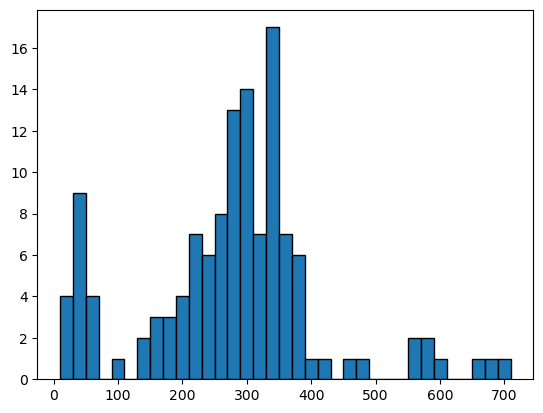

In [13]:
data = ens_nobs._object['nobs_total'].compute().values

bin_edges = range(min(data), max(data) + 21, 20) 
plt.hist(data, bins=bin_edges, edgecolor='k')  # 'k' sets black color for edges

## computation 

In [2]:
# 9min, 13 sec on baldur, for 603 sources in 4 partitions
# 7min, 30 sec on baldur, for 603 sources in 4 partitions, Nov 7
# 5min, 14 sec on baldur, for 603 sources in 10 partitions, Nov 7
# 2min, 50 sec on baldur, for 127 sources in 4 partitions
# 5min, 3 sec on epyc, for 127 sources in 4 partitions
JaxPeriodDrwFit_instance = JaxPeriodDrwFit.JaxPeriodDrwFit()
res_tsp = ens.batch(JaxPeriodDrwFit_instance.optimize_map, 'mjd_ztf_source', "mag_ztf_source", "magerr_ztf_source",
                compute=True, meta=None, n_init=100)

NameError: name 'JaxPeriodDrwFit' is not defined

In [ ]:
JaxPeriodDrwFit_instance = JaxPeriodDrwFit.JaxPeriodDrwFit()
res_tsp_drw = ens.batch(JaxPeriodDrwFit_instance.optimize_map_drw, 'mjd_ztf_source', "mag_ztf_source", "magerr_ztf_source",
                compute=True, meta=None, n_init=100)

In [ ]:
def pack_output_to_parquet(result, cols, output_dir, output_filename, drop_cols=[], full=False):
    """Packs output to a dataframe, written as a parquet file. The created dataframe object is returned for inspection."""
    result_df = None
    if full:
        # Construct dataframes with the results for each object.
        dfs = []
        for i in range(len(result)):
            obj_data = result.iloc[i]
            # Construct a series representing the index
            obj_index = pd.Series(np.full(len(obj_data), result.index[i]), name=result.index.name)
            dfs.append(pd.DataFrame(data=obj_data, columns=cols, index=obj_index))

        # Concatenate all of the per-object dataframes
        result_df = pd.concat(dfs)
    else:
        # Each object only has a 1D array in the result series, so the constructed
        # dataframe has the same number of rows. So we can just do a 1:1 mapping with column names 
        result_df = pd.DataFrame(columns=cols, index=result.index)
        for i in range(len(result)):
            result_df.iloc[i] = result[i]

    # Drop any columns if requested.
    if drop_cols:
        result_df = result_df.drop(columns=drop_cols)

    # Write the output to the parquet file
    pa_table = pa.Table.from_pandas(result_df)
    pa_table
    pa.parquet.write_table(pa_table, f"{output_dir}/data/{output_filename}.parquet")
    return result_df

# Create columns for result of using just the drw kernel
param_cols = ['log_drw_scale', 'log_drw_amp']
init_param_cols = ["init_" + c for c in param_cols]
drw_columns = ['min_neg_log_lh', 'neg_log_lh'] + param_cols + init_param_cols

# Create columns for result of combining the drw params with periodic params
param_cols = ['log_drw_scale', 'log_drw_amp', 'log_per_scale', 'log_per_amp']
init_param_cols = ["init_" + c for c in param_cols]
combined_columns = ['min_neg_log_lh', 'neg_log_lh'] + param_cols + init_param_cols

In [ ]:
# Save output for results from just the drw kernel
drw_df = pack_output_to_parquet(res_tsp_drw, drw_columns,
                       f"/astro/users/{username}", "res_tsp_run_g_0_drw")
drw_df

In [ ]:
# Save output for results from the combined drw and periodic kernel
combined_df = pack_output_to_parquet(res_tsp, combined_columns,
                       f"/astro/users/{username}", "res_tsp_run_g_0")
combined_df

## Redo but save all results (full=True)

In [ ]:
JaxPeriodDrwFit_instance = JaxPeriodDrwFit.JaxPeriodDrwFit()
res_tsp_full = ens.batch(JaxPeriodDrwFit_instance.optimize_map, 'mjd_ztf_source', "mag_ztf_source", "magerr_ztf_source",
                compute=True, meta=None, n_init=100, full=True)

In [ ]:
JaxPeriodDrwFit_instance = JaxPeriodDrwFit.JaxPeriodDrwFit()
res_tsp_drw_full = ens.batch(JaxPeriodDrwFit_instance.optimize_map_drw, 'mjd_ztf_source', "mag_ztf_source", "magerr_ztf_source",
                compute=True, meta=None, n_init=100, full=True)

In [ ]:
# Save output for results from just the drw kernel
drw_df_full = pack_output_to_parquet(res_tsp_drw_full, drw_columns,
                       f"/astro/users/{username}", "res_tsp_run_g_0_drw_full", full=True)
drw_df_full

In [ ]:
# Save output for results from the combined drw and periodic kernel
combined_df_full = pack_output_to_parquet(res_tsp_full, combined_columns,
                       f"/astro/users/{username}", "res_tsp_run_g_0_full", full=True)
combined_df_full

In [1]:
res_tsp

NameError: name 'res_tsp' is not defined